<a href="https://colab.research.google.com/github/zzunairaa/my_nlp_notes/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM

| **Gate**                     | **Contains / Formula**               | **Activation** | **Purpose / Function**                                               |
| ---------------------------- | ------------------------------------ | -------------- | -------------------------------------------------------------------- |
|  **Forget Gate (fₜ)**      | ( fₜ = σ(W_f [hₜ₋₁, xₜ] + b_f) )     | Sigmoid (0–1)  | Controls how much of old cell memory ( Cₜ₋₁ ) to keep or discard     |
|  **Input Gate (iₜ)**       | ( iₜ = σ(W_i [hₜ₋₁, xₜ] + b_i) )     | Sigmoid (0–1)  | Controls how much of the *new candidate memory* to write into ( Cₜ ) |
|  **Candidate Memory (Ĉₜ)** | ( Ĉₜ = \tanh(W_c [hₜ₋₁, xₜ] + b_c) ) | tanh (−1 to 1) | Creates *the actual new content* that could be written into memory   |
|  **Cell State (Cₜ)**       | ( Cₜ = fₜ*Cₜ₋₁ + iₜ*Ĉₜ )             | —              | The long-term memory after combining old (kept) and new (added) info |
|  **Output Gate (oₜ)**      | ( oₜ = σ(W_o [hₜ₋₁, xₜ] + b_o) )     | Sigmoid (0–1)  | Decides what part of updated memory to output                        |
|  **Hidden State (hₜ)**     | ( hₜ = oₜ * \tanh(Cₜ) )              | tanh (−1 to 1) | The *visible output* and short-term memory for next step             |


| Role         | Symbol | Think of It As                      |
| ------------ | ------ | ----------------------------------- |
| Forget gate  | fₜ     |  “How much of the past to forget” |
| Input gate   | iₜ     |  “How much new info to write”     |
| Candidate    | Ĉₜ     |  “What the new info looks like”   |
| Cell state   | Cₜ     |  “The memory notebook”            |
| Output gate  | oₜ     |  “What to show from memory”       |
| Hidden state | hₜ     |  “What you say out loud”         |




##  Goal:

At each time step, the LSTM reads a word embedding (x_t),
updates its memory and hidden state,
and then **predicts the next word** based on (h_t).

---

#  Step-by-Step Flow for Next Word Prediction

---

### ** Step 1: Input the Current Word**

* You feed in the embedding of the current word (x_t).
* Along with it, the model receives:

  * (h_{t-1}): hidden state from the previous step
  * (C_{t-1}): cell state from the previous step

So the input to the cell is:
[
x_t, ; h_{t-1}, ; C_{t-1}
]

---

### ** Step 2: Forget Old Information**

* The **Forget Gate** decides what parts of old memory (C_{t-1}) to erase.

[
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
]

Meaning:

* If (f_t[i] = 1): keep that piece of old memory.
* If (f_t[i] = 0): forget it completely.

---

### ** Step 3: Decide What New Info to Add**

The **Input Gate** controls *how much new info* enters the memory.

[
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)
]

Then, generate the **Candidate Memory** — what the new info *looks like*:

[
\tilde{C_t} = \tanh(W_c [h_{t-1}, x_t] + b_c)
]

 Meaning:

* Candidate = potential new info from current word
* Input gate = permission level for that info

---

### ** Step 4: Update the Memory (Cell State)**

Now, the cell combines **old** and **new** memory:

[
C_t = f_t * C_{t-1} + i_t * \tilde{C_t}
]

 Meaning:

* Keep some old knowledge (via forget gate)
* Add some new context (via input gate)

 This updated (C_t) is the **long-term memory** of the model —
carried to future steps so it can remember context over long distances.

---

### ** Step 5: Decide What to Output (Output Gate)**

The **Output Gate** decides what portion of the updated memory to reveal now.

[
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)
]

---

### ** Step 6: Compute the Hidden State**

Finally, the hidden state (short-term output) is computed:

[
h_t = o_t * \tanh(C_t)
]

 This (h_t) now contains:

* The meaning of the current context (updated by this word)
* Enough info to predict the *next* word.

---

### ** Step 7: Predict the Next Word**

The hidden state (h_t) goes into a **fully connected (linear) layer**
followed by a **softmax** to get probabilities for the next word.

[
\hat{y_t} = \text{softmax}(W_y h_t + b_y)
]

 Meaning:

* Each neuron in ( \hat{y_t} ) = probability of a specific word in the vocabulary.
* The word with the **highest probability** is the **predicted next word**.









In [1]:
import numpy as np

# ---- Helper Functions ----
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# ---- LSTM Cell Implementation ----
class LSTMCell:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Weight matrices for gates (combined input + hidden)
        concat_size = input_size + hidden_size

        self.Wf = np.random.randn(hidden_size, concat_size) * 0.1  # Forget gate
        self.Wi = np.random.randn(hidden_size, concat_size) * 0.1  # Input gate
        self.Wc = np.random.randn(hidden_size, concat_size) * 0.1  # Candidate
        self.Wo = np.random.randn(hidden_size, concat_size) * 0.1  # Output gate

        # Biases for each gate
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

        # Output layer (for next word prediction)
        self.Wy = np.random.randn(output_size, hidden_size) * 0.1
        self.by = np.zeros((output_size, 1))

    def forward(self, x_t, h_prev, C_prev):
        # 1️ Concatenate input and previous hidden
        z = np.vstack((h_prev, x_t))  # shape = (hidden + input, 1)

        # 2️ Forget gate
        f_t = sigmoid(np.dot(self.Wf, z) + self.bf)

        # 3️ Input gate
        i_t = sigmoid(np.dot(self.Wi, z) + self.bi)

        # 4️ Candidate memory
        C_tilde = tanh(np.dot(self.Wc, z) + self.bc)

        # 5️ Update cell state
        C_t = f_t * C_prev + i_t * C_tilde

        # 6️ Output gate
        o_t = sigmoid(np.dot(self.Wo, z) + self.bo)

        # 7️ Hidden state
        h_t = o_t * tanh(C_t)

        # 8️ Prediction for next word (softmax output)
        y_t = np.dot(self.Wy, h_t) + self.by
        y_hat = np.exp(y_t) / np.sum(np.exp(y_t))  # softmax

        # Return all intermediate values (so we can inspect)
        return h_t, C_t, y_hat, (f_t, i_t, C_tilde, o_t)


In [3]:
# ---- Hyperparameters ----
input_size = 4   # dimension of embedding
hidden_size = 6  # number of LSTM neurons
output_size = 5  # pretend we have 5 words in vocab

# Initialize LSTM cell
lstm = LSTMCell(input_size, hidden_size, output_size)

# Initial hidden and cell states, both are empty
h_prev = np.zeros((hidden_size, 1))
C_prev = np.zeros((hidden_size, 1))

# Sample "word embeddings" for a short sequence (3 words)
np.random.seed(1)
sequence = [np.random.randn(input_size, 1) for _ in range(3)]

# ---- Forward through sequence ----
for t, x_t in enumerate(sequence, start=1):
    print(f"\n🕐 Time Step {t}")
    h_prev, C_prev, y_hat, (f_t, i_t, C_tilde, o_t) = lstm.forward(x_t, h_prev, C_prev)

    print("Forget Gate f_t:", f_t.ravel())
    print("Input Gate i_t :", i_t.ravel())
    print("Candidate Ĉ_t  :", C_tilde.ravel())
    print("Updated Cell C_t:", C_prev.ravel())
    print("Output Gate o_t:", o_t.ravel())
    print("Hidden h_t:", h_prev.ravel())
    print("Predicted Next Word Probabilities (softmax):", y_hat.ravel())



🕐 Time Step 1
Forget Gate f_t: [0.47664431 0.50078572 0.58165869 0.50092533 0.47443644 0.63895839]
Input Gate i_t : [0.50601028 0.46692361 0.43753262 0.49836757 0.56011156 0.4567921 ]
Candidate Ĉ_t  : [ 0.14709731  0.2670082   0.20290211  0.38787645  0.16215701 -0.05082497]
Updated Cell C_t: [ 0.07443275  0.12467243  0.08877629  0.19330504  0.09082602 -0.02321644]
Output Gate o_t: [0.50014805 0.4650228  0.52033628 0.46610233 0.43469101 0.60275599]
Hidden h_t: [ 0.0371588   0.057677    0.04607255  0.08899421  0.03937305 -0.01399134]
Predicted Next Word Probabilities (softmax): [0.19871997 0.19639208 0.20126966 0.20287529 0.200743  ]

🕐 Time Step 2
Forget Gate f_t: [0.39721399 0.44260715 0.49789767 0.48672764 0.39987098 0.57470505]
Input Gate i_t : [0.45208856 0.48688899 0.40386417 0.42837543 0.51196785 0.43447188]
Candidate Ĉ_t  : [ 0.03421366  0.00492324  0.25678201  0.42030974 -0.10130659  0.21713938]
Updated Cell C_t: [ 0.04503333  0.05757798  0.14790656  0.27413727 -0.01554703  0.0

In [6]:
import torch
import torch.nn as nn

class MyLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(MyLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True) #it computes the steps we have seen manual
        self.fc = nn.Linear(hidden_dim, vocab_size) #nn.Linear(in_features=hidden_dim, out_features=vocab_size)
#nn.linear is needed for the computation of output
    def forward(self, x, h=None):
        x = self.embedding(x) #converts word indices into dense embedding vector
        out, (h, c) = self.lstm(x, h) #LSTM layer process the entire sequence
        out = self.fc(out)
        return out, (h, c)

# Example usage
vocab_size = 100
model = MyLSTMModel(vocab_size, embed_dim=10, hidden_dim=20)

# A batch with one sentence of 5 words (token IDs)
inputs = torch.randint(0, vocab_size, (1, 5))
outputs, _ = model(inputs)

print("Input IDs :", inputs)
print("Output logits shape:", outputs.shape)  # (1, 5, vocab_size)


Input IDs : tensor([[31, 60, 23, 31, 73]])
Output logits shape: torch.Size([1, 5, 100])


x is a batch of word indices integers representing words in your vocabulary.

***out, (h, c) = self.lstm(x, h)***
Here the LSTM layer processes the entire sequence.
This is where all your “forget”, “input”, and “output” gates from before actually work.

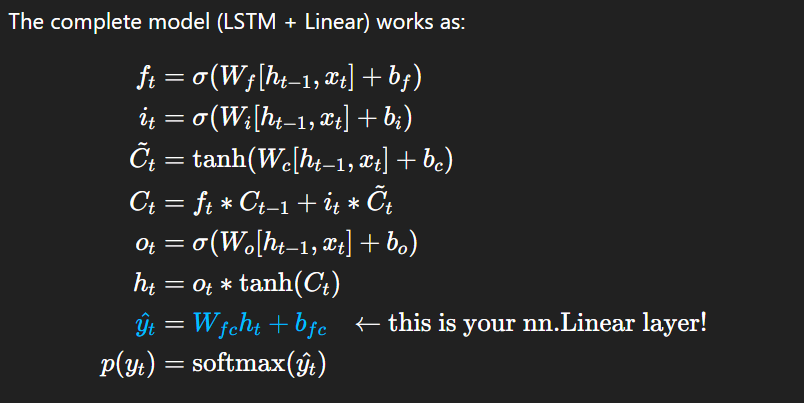

| Problem in RNN                                                                                                   | How LSTM fixes it                                                                                       |
| ---------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **1️ Vanishing gradients** — RNNs forget long-ago words because their gradients shrink as sequences get longer. |  LSTM adds a **cell state** that carries information across many time steps, keeping gradients stable. |
| **2️ No control over what to remember or forget**                                                               |  LSTM uses **three gates** (input, forget, output) to *selectively* store or discard information.      |
| **3️ Poor at long-term dependencies** — can’t connect “If … then …” patterns far apart.                         |  LSTM can remember context over long distances — ideal for long sentences, paragraphs, or time series. |
| **4️ Easily loses context**                                                                                     | LSTM preserves relevant context with its internal memory mechanism.                                   |




###  **Limitations of LSTM :**

1️ **Slow training**  processes words one by one (can’t parallelize).

2️ **Hard to handle very long sequences**  still forgets distant information.

3️ **Computationally heavy**  many parameters (four gates).

4️ **Difficult to interpret**  we can’t easily see what it “remembers.”

5️ **Not scalable**  struggles with very large datasets compared to Transformers.

